We'll start by using the [markovify](https://github.com/jsvine/markovify/) library to make some social-media-sized utterances in the style of Jane Austen.  This will be the basis for generating a synthetic social media stream.

In [1]:
import markovify
import codecs

with codecs.open("austen.txt", "r", "cp1252") as f:
    text = f.read()

austen_model = markovify.Text(text, retain_original=False, state_size=3)

for i in range(10):
    print(austen_model.make_short_sentence(200))

He began by speaking of her with so much dignified impertinence.
You should not have been.
Emma was sadly fearful that this second disappointment would be more becoming in her not to neglect it on any account.
Although I had always despised her from the evil of a restless, officious companion, too apt to look.
He has a fine dignified manner, which suits the head of the sinner; for when poor Lady Elliot died herself, no letter of condolence had been sent to Ireland.
On the morrow the Crawfords were engaged to me ever since my marriage, I had seen Marianne's sweet face as white as my gown.
Ought he not to have attempted more.
His aunt worried him by her manner this morning, and cannot get the better of those false ideas of the necessity of reading aloud, which had fallen within his observation, that he had _cause_ to sigh.
It was, indeed, a highly prized letter.
For you alone, I think and plan.


We'll use spaCy to identify entities (mostly proper nouns and noun phrases) in these synthetic status updates and turn them into hashtags:

In [2]:
import spacy
nlp = spacy.load('en')

def make_sentence(model, length=200):
    return model.make_short_sentence(length)
    
def hashtagify_full(sentence):
    doc = nlp(sentence)
    for ent in doc.ents:
        sentence = sentence.replace(str(ent), "#%s" % str(ent).replace(" ", ""))
    return (sentence, ["#%s" % str(ent).replace(" ", "") for ent in doc.ents])

def hashtagify(sentence):
    result,_ = hashtagify_full(sentence)
    return result

for i in range(5):
    sentence = make_sentence(austen_model)
    print(sentence)
    print(hashtagify(sentence))

I hope you will do him such ample justice, that I am an advocate for marriage without love?
I hope you will do him such ample justice, that I am an advocate for marriage without love?
Chapter 14 Though Charles and Mary still talked on in the same place, was bad for each, for all three.
Chapter 14 Though #Charles and #Mary still talked on in the same place, was bad for each, for all #three.
Fanny Price was at this time of year.
#FannyPrice was at #thistimeofyear.
It was a happy woman, and a very few weeks would be sufficient for such arrangements as must precede the wedding.
It was a happy woman, and #averyfewweeks would be sufficient for such arrangements as must precede the wedding.
Mary had no feelings to make her resolve on remaining at Norland no longer than was unavoidable, it had not afforded.
Mary had no feelings to make her resolve on remaining at #Norland no longer than was unavoidable, it had not afforded.


We'll now train two Markov models on positive and negative product reviews (taken from the [public-domain Amazon fine foods reviews dataset on Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews/)).  We'll incorporate the results of these models into our synthetic social media stream.

In [3]:
import gzip

def train_markov_gz(fn):
    """ trains a Markov model on gzipped text data """
    with gzip.open(fn, "rt", encoding="utf-8") as f:
        text = f.read()
    return markovify.Text(text, retain_original=False, state_size=3)

negative_model = train_markov_gz("reviews-1.txt.gz")
positive_model = train_markov_gz("reviews-5-100k.txt.gz")

In [4]:
make_sentence(negative_model)

'Ick.'

In [5]:
make_sentence(positive_model)

'Great stuff.'

We can combine these models with relative weights, but this yields somewhat unusual results:

In [6]:
compound_model = markovify.combine([austen_model, negative_model, positive_model], [14, 3, 3])

In [7]:
for i in range(20):
    print(hashtagify(make_sentence(compound_model)))

Anyway, the whole family and they all came in sugar free!!!But they are wonderful you will not go.
There was also a good idea to use very much to have enjoyed their unique taste.
This is one I fix when I don't have any scent that other ingredients might individually offer.
Not astonishingly strong, but pretty rich and balanced.
Several of them broke open in the pot and could not touch it; and #Emma, never loth to be #first, was obliged to repeat again and again, as if nothing were a security for matrimonial comfort.
#MapleGrove will probably be ordering more.
I bought these as a child . If you like soft licorice - then don't buy this.
This tea is so horrible. i cannot believe all the hype on this product and the best of both worlds: the vitamins/minerals of a fortified cereal without all of the grocery stores #today.
However what I received #today...
She had been bounced around from house to house and eating whatever was cheap.
I love to make cake pops.
It's really too bad because its 

As is more or less the case in the real world, we'll assume that a small percentage of users are responsible for the bulk of social media activity, and that the bulk of users are responsible for relatively few posts.  We'll model this with a table of random user IDs that has a collection of relatively few talkative users and relatively many moderate users; the proportion of utterances from talkative users to utterances from moderate users is the inverse of the proportion of talkative users to moderate users.

In [8]:
import numpy
import math
import collections

class UserTable(object):
    def __init__(self, size, weights=[8, 2]):
        self._talkative = collections.deque()
        self._moderate = collections.deque()
        self._size = size
        self._cutoff = float(weights[0]) / sum(weights)
        
        for i in range(size):
            new_uid = math.floor(numpy.random.uniform(10 ** 10))
            if numpy.random.uniform() >= self._cutoff:
                self._moderate.append(new_uid)
            else:
                self._talkative.append(new_uid)
    
    def random_uid(self):
        def choose_from(c):
            return c[math.floor(numpy.random.uniform() * len(c))]
        
        if numpy.random.uniform() >= self._cutoff:
            return choose_from(self._talkative)
        else:
            return choose_from(self._moderate)
        

In [9]:
import seaborn

We can see the number of times each user ID appears if we ask the `UserTable` for 1000 random user IDs:

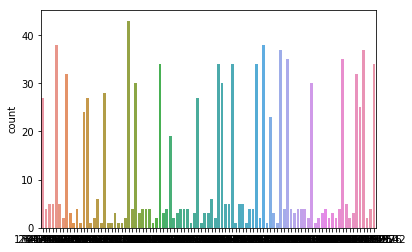

In [10]:
ut = UserTable(100)
uids = [ut.random_uid() for i in range(1000)]
seaborn.countplot(uids)

In [32]:
def generate_tweets(models, weights=None, hashtag_weights=[8, 2], ut=None, seed_hashtags=[]):
    if weights is None:
        weights = [1] * len(models)
    
    if ut is None:
        ut = UserTable(10000)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]
    
    seen_hashtags = set()
    hashtags = []
    total_hashtag_weight = float(sum(hashtag_weights))
    for i in range(len(hashtag_weights)): 
        hashtags.append((float(sum(hashtag_weights[0:i+1])) / total_hashtag_weight, collections.deque()))
    
    iws = [1.0 - w for (w, _) in hashtags]
    inverse_weights = [(sum(iws[0:i+1]), i) for _, i in zip(iws, range(len(iws)))]    

    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    def store_hashtag(tag):
        if tag not in seen_hashtags:
            seen_hashtags.add(str(tag))
            r = numpy.random.uniform()
            for(p, deq) in hashtags:
                if r <= p:
                    deq.append(tag)
    
    def choose_hashtag():
        r = numpy.random.uniform()
        for(p, i) in hashtags:
            if r <= - p and len(hashtags[i][1]) > 0:
                return choose_from(hashtags[i][1])
        return len(hashtags[0][1]) > 0 and choose_from(hashtags[0][1]) or choose_from(hashtags[1][1])
    
    for tag in seed_hashtags:
        seen_hashtags.add(str(tag))
        hashtags[-1][1].append(str(tag))
    
    while True:
        tweet, tags = hashtagify_full(make_sentence(choose_model()))
        for tag in tags:
            store_hashtag(str(tag))
        
        this_tweet_tags = set([str(t) for t in tags])
        
        if len(seen_hashtags) > 0:
            for i in range(min(numpy.random.poisson(3), len(seen_hashtags))):
                tag = choose_hashtag()
                if str(tag) not in this_tweet_tags:
                    this_tweet_tags.add(str(tag))
                    tweet += " %s" % str(tag)
            
        yield (ut.random_uid(), tweet)

In [33]:
seed_hashtags=["#ff", "#marketing", "#fail", "#followfriday", "#yolo", "#retweet", "#tbt", "#socialmedia", "#startup", "#blogpost", "#news", "#health"]

t = generate_tweets([austen_model, positive_model, negative_model, compound_model], [22, 4, 4, 2], seed_hashtags=seed_hashtags)

In [34]:
t

<generator object generate_tweets at 0x1ae77b1990>

In [35]:
[next(t) for i in range(100)]

[(4919108956,
  'If a woman conceals her affection with the same intent, just then the stoutest of the #three; for the very exertion to which he was to proceed on his journey to Town. #health'),
 (2321890080,
  'It has protein as well, which I appreciate as a mom. #fail #retweet #tbt'),
 (8288438770,
  "Yes, that's how good these blueberries are! #startup #health #yolo #socialmedia"),
 (3873645654,
  "Mr. #Elton's engagement in the conversation of Mr #Cleveland. #three #news #ff"),
 (2866175761,
  'It was impossible for her not to be supposed that he would still love, and still hope! #health #three'),
 (9553742504,
  'In such a frame of mind as she was resettled, was looking forward with eagerness. #yolo #news'),
 (7212767217,
  'Depend upon it, that is a place, indeed, and we had a rehearsal. #Cleveland #ff'),
 (4953926703,
  "I wouldn't stop taking this tea for menstral cramps. #followfriday #marketing #socialmedia #yolo"),
 (9760872753, 'Clearly adictive #Haribo product. #news #fail

In [ ]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [ ]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()

In [ ]:
import pstats
p = pstats.Stats('generatestats-old')
p.strip_dirs().sort_stats(-1).print_stats()